In [1]:
import pandas as pd
import numpy as np
import torch
import os, time, glob
import matplotlib.pyplot as plt
%matplotlib inline

# 檢查系統與軟體版本
print(pd.__version__)
print(np.__version__)
print(torch.__version__)
!python -V
# !uname  -srvm
# !lscpu  | grep "Model name:" # 檢查CPU資訊
# !nvidia-smi # 檢查GPU資訊

model_name  =  f'Resnet50_210325'
path = f'./checkpoint/{model_name}.pth'

1.0.3
1.18.1
1.4.0
Python 3.6.10


## 1. 準備資料集

### 1.1 載入資料

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# 讀取csv檔
csv_path = 'sp_meta.csv'
df = pd.read_csv(csv_path, sep='\t')
print(df.shape[0]) # 74335

# 取得影像檔名
df['ImgName'] = df.Number+'.jpg'

# 取得各物種海拔均值與樣本數
alt_mean = (df.groupby('Species')['Alt'].agg([np.mean, np.size])
              .rename(columns={'mean':'Alt_Mean', 'size':'Count'}).reset_index())

# (df.groupby('Species').agg(Alt_Mean = pd.NamedAgg( "Alt", "min"),
#                            Count = pd.NamedAgg( "Alt", "size"))).reset_index())

df = pd.merge(df, alt_mean, on='Species' ,how='right')  # 依照物種欄位合併，物種名稱有缺值的會直接去除  get n=53753
print(df.shape[0]) # 53753
df = shuffle(df, random_state=10) # 洗牌打亂順序


74335
53753


### 1.1.1 按比例切分樣本

In [3]:
# sp_list = df.Species.unique() # 取得物種名錄

# for i,sp in enumerate(sp_list):
#     sp_s = (df.Species== sp_list[i])
#     X = df[sp_s].loc[:, 'ImgName']
#     y = df[sp_s].loc[:, 'Alt_Mean']
# #     print(sp_list[i],data[sp_s].shape[0])

#     if df[sp_s].shape[0]>=3: # 當樣本數3以上
# #         print(sp_list[i],df[sp_s].shape[0])

#         X_train_t, X_test_t , y_train_t, y_test_t   = train_test_split(X, y , test_size=0.2)
#         X_train_t, X_valid_t, y_train_t, y_valid_t  = train_test_split(X_train_t, y_train_t, test_size=0.2)
        
#         if i == 0:
#             X_train, y_train =  X_train_t, y_train_t
#             X_valid, y_valid =  X_valid_t, y_valid_t
#             X_test , y_test  =  X_test_t , y_test_t

#         else:
#             X_train, y_train = np.concatenate((X_train_t, X_train)), np.concatenate((y_train_t, y_train))
#             X_valid, y_valid = np.concatenate((X_valid_t, X_valid)), np.concatenate((y_valid_t, y_valid))
#             X_test , y_test  = np.concatenate((X_test_t, X_test)), np.concatenate((y_test_t, y_test))
            
# #     if df[sp_s].shape[0]==2:  # 當樣本數為2，分配給train,valid各一半
# #         X_train_t, X_valid_t, y_train_t, y_valid_t  = train_test_split(X, y, test_size=0.5)
# #         X_train, y_train = np.concatenate((X_train_t, X_train)), np.concatenate((y_train_t, y_train))
# #         X_valid, y_valid = np.concatenate((X_valid_t, X_valid)), np.concatenate((y_valid_t, y_valid))
        
# #     if df[sp_s].shape[0]==1:  # 當樣本數為１，全部分配給train
# #         X_train, y_train = np.concatenate((X, X_train)), np.concatenate((y, y_train)) 
# print(f'Total: {X_train.shape[0]+X_valid.shape[0]+X_test.shape[0]}\n  train: {X_train.shape[0]}\n  valid: {X_valid.shape[0]}\n  test : {X_test.shape[0]}')

# # save meta data 
# pd.DataFrame({'ImgName':X_train, 'Alt_Mean':y_train}).to_csv(f'./meta/train_3.csv')
# pd.DataFrame({'ImgName':X_valid, 'Alt_Mean':y_valid}).to_csv(f'./meta/valid_3.csv')
# pd.DataFrame({'ImgName':X_test , 'Alt_Mean': y_test}).to_csv(f'./meta/test_3.csv')

In [4]:
#load meta data 
tra,val,test = [pd.read_csv(f'./meta/{name}_all.csv', index_col=0) for name in ['train','valid','test']]
X_train, y_train =  tra.ImgName,  tra.Alt_Mean
X_valid, y_valid =  val.ImgName,  val.Alt_Mean
X_test,  y_test  = test.ImgName, test.Alt_Mean

### 1.1.2 隨機切分樣本　

In [5]:
# from sklearn.model_selection import train_test_split
# X, y = df.loc[:, 'ImgName'], df.loc[:, 'Alt_Mean']

# print(X.shape[0])
# # 切分資料
# random_state = 50 # 設定隨機狀態

# # 先將資料切20%為測試資料，再將剩下的訓練資料切分20%為驗證資料
# X_train, X_test, y_train, y_test    = train_test_split(X, y, test_size=0.2, random_state=random_state)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)
# print(f'Total: {X_train.shape[0]+X_valid.shape[0]+X_test.shape[0]}\n  train: {X_train.shape[0]}\n  valid: {X_valid.shape[0]}\n  test : {X_test.shape[0]}')


#### 載入自定義的客製資料集

In [6]:
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import scripts.mothDataset as myDataset # 從script 資料夾的　mothDataset.py檔案中，引入mothDataset這個類別

In [7]:
# 指定資料轉型、增強方式
mean = np.array([0.70, 0.70, 0.70])
std  = np.array([0.25, 0.25, 0.25])
# mean=np.array([0.485, 0.456, 0.406]); std=np.array([0.229, 0.224, 0.225]) #setting of YY
size=(224, 224)

train_transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2),              #　改變透視扭曲程度
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.1, hue=0.1),                #　改變色彩
    transforms.RandomAffine(degrees=5, shear=5, scale=(0.9,1.1)),  #　選轉角度、變焦、縮放、改變剪切角度    
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop((224,224)),
    transforms.RandomRotation(20),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)])   

test_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)])

In [8]:
root = './downloaded256/'
csv_path = 'sp_meta.csv'

# 設定參數
batch_size  = 64    # 可塞入記憶體的最大批次
num_workers = 4
pin_memory  = True
drop_last   = True

# 客製Dataset載入資料
train_set = myDataset.MothImgDataset(image_root=root, X=X_train, y=y_train, transform= train_transform)
valid_set = myDataset.MothImgDataset(image_root=root, X=X_valid, y=y_valid, transform=  test_transform)
test_set  = myDataset.MothImgDataset(image_root=root, X= X_test, y= y_test, transform=  test_transform)

# DataLoader將資料把包成批次
train_loader = DataLoader(dataset=train_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory, drop_last=drop_last)
valid_loader = DataLoader(dataset=valid_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)
test_loader  = DataLoader(dataset= test_set, shuffle=False,num_workers=num_workers, batch_size=96, pin_memory=pin_memory)


In [9]:
# # 檢視資料形狀、大小
# print(f'Train size : {len(train_set):5d}, iter_size: {len(train_loader):4d}')
# print(f'Valid size : {len(valid_set):5d}, iter_size: {len(valid_loader):4d}')
# print(f' Test size : { len(test_set):5d}, iter_size: { len(test_loader):4d}')

# images, labels = next(iter(train_loader))
# print('Train data set:', images.shape, labels.shape)   # (batch_size, channel, w, h) 
# images, labels = next(iter(valid_loader))
# print('Valid data set:', images.shape, labels.shape)   # (batch_size, channel, w, h) 
# images, labels = next(iter(test_loader))
# print(' Test data set:', images.shape, labels.shape)   # (batch_size, channel, w, h) 

#### 資料視覺化

In [10]:
import matplotlib.pyplot as plt
import torchvision 

def im_convert(tensor):  
    image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
    image = image.transpose(1, 2, 0)              # (c,w,h) > (w,h,c)
    image = image*std + mean                      # unnormalize
#     image = image.clip(0, 1)
    plt.imshow(image)


In [11]:
# # 隨機讀取圖片
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# # 顯示圖片
# im_convert(torchvision.utils.make_grid(images[:15], nrow=5, 
#                                        padding=1, normalize=False, range=None, scale_each=False))

## 2. 定義神經網路(CNN)

### 載入預先訓練好的模型

In [12]:
# 指定GPU位置
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
with torch.cuda.device('cuda:1'):
    torch.cuda.empty_cache()

In [13]:
from torchvision import models
import torch.nn as nn
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
model = model.to(device) 

In [14]:
# # 評估模型摘要
# input_size = (3, 256, 256)
# batch_size = 32
# from torchsummary import summary
# summary(model.to(device), input_size=input_size, batch_size=batch_size, device='cuda')


## 3. 定義損失函數和最佳化器(Loss 、Optimizer)

In [20]:
from torch import  nn
import torch.optim as optim
from torch.optim import lr_scheduler

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.1)

def set_opt(lr=None, factor=None, weight_decay=None):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=factor, patience=10, verbose=True)
    return optimizer, scheduler


## 4. 訓練模型

#### 模型檢查點(Checkpoint)儲存與載入

In [16]:
# 呼叫模型檢查點(Checkpoint)儲存與載入函式
from scripts.checkpoint import save_checkpoint, load_checkpoint

# 呼叫訓練與評估函式
from scripts import utilities
from scripts.utilities import train, evaluate, save_log, get_LossFig, test, early_stop

log file resetted:
    train_log, valid_log, lr_log


#### 訓練模型

In [23]:
def training_model(n_epoch, optimizer, scheduler):
    best_loss =1e10  ; patience=20 ; trigger_times=0 # 設定初始值
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        print(f'epoch:{epoch+1 :3d}')
        start = time.time()
        train_loss, valid_loss= 0.0, 0.0 # 每輪重新歸零

        train_loss = train(model, optimizer, train_loader, device)
        print(f'  Train Loss: {train_loss:,.0f}')
        valid_loss = evaluate(model, valid_loader, device) # 評估後後取出驗證資料集的loss
        print(f'  Valid Loss: {valid_loss:,.0f}')

        # 擷取最佳模型
        if best_loss > valid_loss:
            decline = (best_loss-valid_loss)/best_loss*100
            best_loss = valid_loss
            save_checkpoint(model, optimizer,path, epoch, best_loss)             
            print(f'  Best loss updated: {best_loss:,.0f}, {decline:.2f}% declined.  Model Saved!') 

        # 更新學習速率
        scheduler.step(valid_loss)
        print(f'  lr_sch : {scheduler._last_lr[0]}')
        
        # 儲存log
        save_log(fileName=model_name)

        # early stopping
        trigger_times = early_stop(valid_loss, best_loss, trigger_times, patience)
        if trigger_times >= patience:
            print('Early stopping!')
            break

        if epoch%10 ==0 :
            pass_ = time.time() - start
            print(f'  Time passed per epoch: {pass_//60 :.0f}m {pass_%60:.0f}s')
            
    print(f'Best val_loss: {best_loss:,.0f}')
    print(f'Finished Training.')
    

In [18]:
# train_log, valid_log, lr_log  = [], [], []

In [ ]:
# 先逐步預熱模型
optimizer, scheduler = set_opt(lr=1e-7, factor=0.1, weight_decay=0)
print('\nlr reduced to 1e-7')
training_model(10, optimizer, scheduler)

optimizer, scheduler = set_opt(lr=1e-6, factor=0.1, weight_decay=0)
print('\nlr reduced to 1e-6')
training_model(10, optimizer, scheduler)

save_checkpoint(model, optimizer, path=f'./checkpoint/{model_name}_warm.pth' , epoch=20)  #預存個剛熱好機的模型


lr reduced to 1e-7
epoch:  1
  Train Loss: 893,291
  Valid Loss: 940,126
  Best loss updated: 940,126, 99.99% declined.  Model Saved!
  lr_sch : 1e-07
  Time passed per epoch: 3m 28s
epoch:  2
  Train Loss: 892,632
  Valid Loss: 940,988
  lr_sch : 1e-07
  trigger times: 1
epoch:  3
  Train Loss: 892,663
  Valid Loss: 939,758
  Best loss updated: 939,758, 0.04% declined.  Model Saved!
  lr_sch : 1e-07
epoch:  4
  Train Loss: 892,485
  Valid Loss: 940,541
  lr_sch : 1e-07
  trigger times: 1
epoch:  5
  Train Loss: 892,311
  Valid Loss: 941,344
  lr_sch : 1e-07
  trigger times: 2
epoch:  6


In [ ]:
# 正式開始訓練
batch_size=32  # 從64縮小為16 增加最後微調時的樣本誤差
train_loader = DataLoader(dataset=train_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory, drop_last=drop_last)
valid_loader = DataLoader(dataset=valid_set, shuffle=True, num_workers=num_workers, batch_size=batch_size, pin_memory=pin_memory)

optimizer, scheduler = set_opt(lr=1e-5, factor=0.1, weight_decay=0.1)
training_model(100, optimizer, scheduler)
save_checkpoint(model, optimizer, path=f'./checkpoint/{model_name}_after100.pth' , epoch=20)  #預存個剛熱好機的模型

In [ ]:
get_LossFig(figName=model_name, s=0, e=None, savefig=True)

In [ ]:
# 估計約50輪後會開始卡住，調降下降幅度

# 優化器改為SGD
optimizer = optim.SGD(model.parameters(), lr=1e-6, momentum=0.9 ,weight_decay=0.1)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

training_model(100, optimizer, scheduler)


epoch:  1
  Train Loss: 47,862
  Valid Loss: 77,985
  Best loss updated: 77,985, 100.00% declined.  Model Saved!
  lr_sch : 1e-06
  Time passed per epoch: 3m 14s
epoch:  2
  Train Loss: 44,643
  Valid Loss: 78,153
  lr_sch : 1e-06
  Early stopping trigger times: 1
epoch:  3
  Train Loss: 42,601
  Valid Loss: 75,938
  Best loss updated: 75,938, 2.62% declined.  Model Saved!
  lr_sch : 1e-06
epoch:  4
  Train Loss: 41,672
  Valid Loss: 74,131
  Best loss updated: 74,131, 2.38% declined.  Model Saved!
  lr_sch : 1e-06
epoch:  5
  Train Loss: 41,552
  Valid Loss: 72,758
  Best loss updated: 72,758, 1.85% declined.  Model Saved!
  lr_sch : 1e-06
epoch:  6
  Train Loss: 41,007
  Valid Loss: 75,647
  lr_sch : 1e-06
  Early stopping trigger times: 1
epoch:  7
  Train Loss: 40,211
  Valid Loss: 74,293
  lr_sch : 1e-06
  Early stopping trigger times: 2
epoch:  8
  Train Loss: 39,322
  Valid Loss: 72,435
  Best loss updated: 72,435, 0.44% declined.  Model Saved!
  lr_sch : 1e-06
epoch:  9
  Train

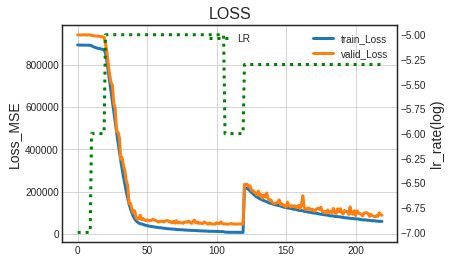

In [17]:
get_LossFig(figName=model_name, s=0, e=None, savefig=True)

In [ ]:
# len(train_log), len(valid_log), len(lr_log)

## 5. 使用測試數據驗證結果


In [18]:
# 載入保存的模型
load_checkpoint(model, optimizer, path, model_name)

best_loss:81246.1501
Resnet50_210325.pth loaded!


Adam (
Parameter Group 0
    amsgrad: False
    dampening: 0
    lr: 5.000000000000001e-06
    momentum: 0.9
    nesterov: False
    weight_decay: 0.1
)

In [ ]:
torch.cuda.empty_cache()  # 清除ＧPU記憶體暫存

In [ ]:
test_loader  = DataLoader(dataset= test_set, shuffle=False,num_workers=num_workers, batch_size=96, pin_memory=pin_memory)

In [ ]:
model.to(device)
y_test, y_pre = test(model, dataloader, device, model_name, save=True)

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
RMSE = mean_squared_error(y_test, y_pre, squared=False)
R2 = r2_score(y_test, y_pre)
print(f"RMSE: {RMSE:.0f}")                
print(f"R2 : {R2:.3f}")

In [ ]:
title_name = f'MothAlt_Pre_{model_name}\n RMSE: {RMSE:.0f}, R2: {R2:.3f}'

fig = plt.figure()
plt.scatter(y_test, y_pre, s=0.7)
plt.xlabel('Real', {'fontsize':12}),plt.ylabel('Pred', {'fontsize':14})
plt.title(title_name, {'fontsize':14})
fig.show();

# 圖片存檔
time_ = time.strftime("%y%m%d_%H%M")
fig.savefig(f'./figure/MothAlt_Pre_{title_name}.png', bbox_inches='tight')